In [3]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
data = pd.read_csv('C:/Users/Pankaj Aggarwal/Desktop/Data/Time Series/perrin-freres-monthly-champagne-.csv')
data.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
data.tail(5)

,Month,Sales
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


1. Converting the data

In [5]:
data.drop(105,axis=0,inplace=True)
data.drop(106,axis=0,inplace=True)
data.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [6]:
data['Month'] = pd.to_datetime(data['Month'])
data

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0
...,...,...
100,1972-05-01,4618.0
101,1972-06-01,5312.0
102,1972-07-01,4298.0
103,1972-08-01,1413.0


In [7]:
data.set_index('Month', inplace=True)
data

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


2. Visualizing the data

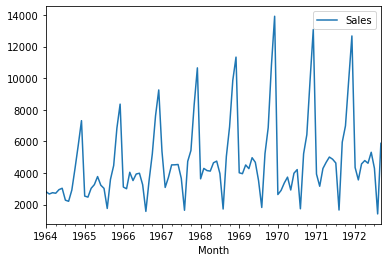

In [8]:
data.plot()  # looks like seasonal trend

3. Checking if the data is stationary or not

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
test = adfuller(data['Sales'])

In [11]:
# Ho - Data is not stationary
# H1 - Data is Stationary
def ad_fuller(Sales):
    result = adfuller(Sales)
    labels = ['Adf Test Statistic', 'P-Value', 'No. of Lags Used', 'No. of Observation Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
        if result[1]<0.05:
            print('Reject Ho')
        else:
            print('Accept Ho')

In [12]:
ad_fuller(data['Sales'])  # Since P-value is greater than 0.05 we have to accept Ho i.e data is non stationary

Adf Test Statistic : -1.8335930563276297
Accept Ho
P-Value : 0.3639157716602417
Accept Ho
No. of Lags Used : 11
Accept Ho
No. of Observation Used : 93
Accept Ho


4. Converting the data into stationary data by differencing

In [13]:
data['Sales first Difference'] = data['Sales']-data['Sales'].shift(1)  # for trends only 
data

,Sales,Sales first Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0
...,...,...
1972-05-01,4618.0,-170.0
1972-06-01,5312.0,694.0
1972-07-01,4298.0,-1014.0


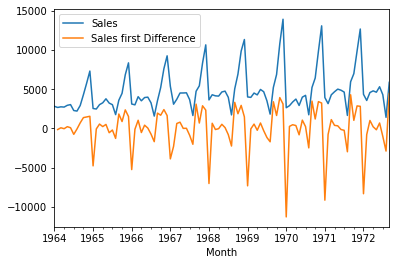

In [14]:
data.plot()

In [15]:
ad_fuller(data['Sales first Difference'].dropna())

Adf Test Statistic : -7.1898964480510195
Reject Ho
P-Value : 2.519620447386778e-10
Reject Ho
No. of Lags Used : 11
Reject Ho
No. of Observation Used : 92
Reject Ho


In [16]:
# Since our data is seasonal we need to use difference of 12

In [17]:
data['Seasonal first Difference'] = data['Sales']-data['Sales'].shift(12)  # for seasonal data
data

,Sales,Sales first Difference,Seasonal first Difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
...,...,...,...
1972-05-01,4618.0,-170.0,-392.0
1972-06-01,5312.0,694.0,438.0
1972-07-01,4298.0,-1014.0,-335.0


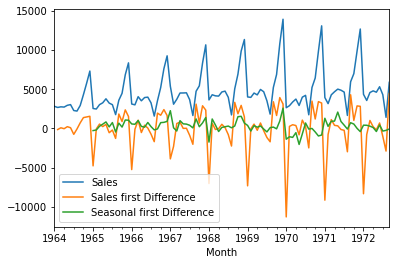

In [18]:
data.plot()  # better looking for seasonal difference

In [19]:
ad_fuller(data['Seasonal first Difference'].dropna())

Adf Test Statistic : -7.626619157213163
Reject Ho
P-Value : 2.060579696813685e-11
Reject Ho
No. of Lags Used : 0
Reject Ho
No. of Observation Used : 92
Reject Ho


5. Now Construct the model

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sm
# Identification of AR model is done by pacf and MA model by acf

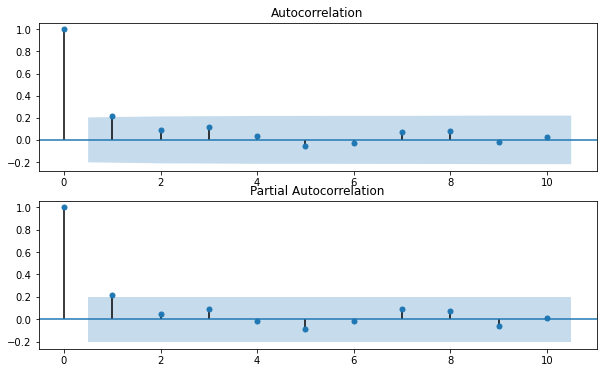

In [21]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.plot_acf(data['Seasonal first Difference'].dropna(),lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.plot_pacf(data['Seasonal first Difference'].dropna(),lags=10, ax=ax2)

In [22]:
# From the graph we can see the p =1 or 2, q=1 or 2, one time we shifted the seasonal data so d=1

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
model = ARIMA(data['Sales'], order = (1,1,1)).fit()
model.summary()

C:\Users\Pankaj Aggarwal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Pankaj Aggarwal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Sat, 24 Oct 2020   AIC                           1910.251
Time:                        23:33:27   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7848     12.405      1.837      0.066      -1.529      47.099
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

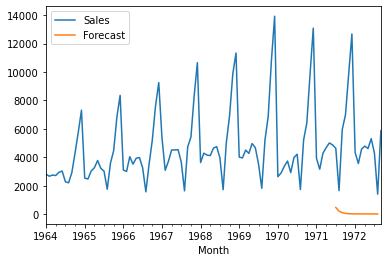

In [25]:
data['Forecast'] = model.predict(start = 90, end = 103, dynamic=True)
data[['Sales','Forecast']].plot()  # since data is seaonal it will not work

In [26]:
data

,Sales,Sales first Difference,Seasonal first Difference,Forecast
Month,,,,
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,-143.0,NaN,NaN
1964-03-01,2755.0,83.0,NaN,NaN
1964-04-01,2721.0,-34.0,NaN,NaN
1964-05-01,2946.0,225.0,NaN,NaN
...,...,...,...,...
1972-05-01,4618.0,-170.0,-392.0,22.892386
1972-06-01,5312.0,694.0,438.0,22.831516
1972-07-01,4298.0,-1014.0,-335.0,22.805078


In [27]:
import statsmodels.api as sm
model_S = sm.tsa.statespace.SARIMAX(data['Sales'],order=(1,1,1), seasonal_order=(1,1,1,12))
result = model_S.fit()
result.summary()

C:\Users\Pankaj Aggarwal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Pankaj Aggarwal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Sat, 24 Oct 2020   AIC                           1486.804
Time:                                    23:33:29   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.335      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (Q):                       40.24   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.46   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
data['Forecast'] = result.predict(start = 95, end = 103, dynamic = True)

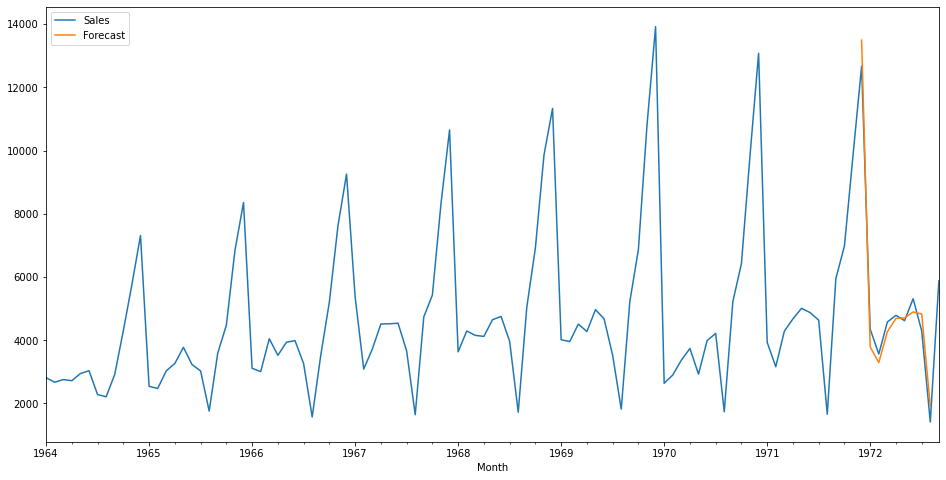

In [29]:
data[['Sales','Forecast']].plot(figsize=(16,8))

In [30]:
from pandas.tseries.offsets import DateOffset

In [31]:
future_dates = [data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [32]:
future_datest_data = pd.DataFrame(index=future_dates[1:],columns=data.columns)
future_datest_data

,Sales,Sales first Difference,Seasonal first Difference,Forecast
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN,NaN
1973-07-01,NaN,NaN,NaN,NaN


In [33]:
future_df = pd.concat([data,future_datest_data])

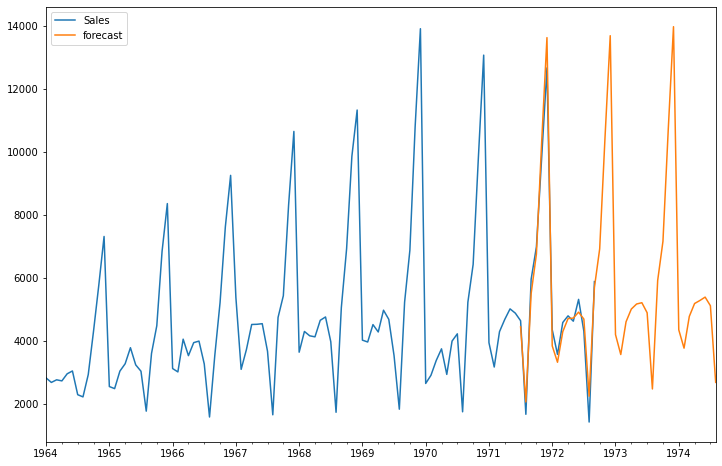

In [34]:
future_df['forecast'] = result.predict(start = 90, end = 130, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 